<a href="https://colab.research.google.com/github/HenokL/HenokL/blob/main/ENSF_611_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ENSF 611 Final Project
# Jonathan Lui 		         Falmata Obsa	           Henok Lamiso
# 30016878                 30235188                30269944

# This project aims to predict used car prices using various car characteristics.

In [ ]:
# Import Libraries
import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [ ]:
# Data Collection
# https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset
# Data Set
path = kagglehub.dataset_download("taeefnajib/used-car-price-prediction-dataset")
print("Path to dataset files:", path)



100%|██████████| 109k/109k [00:00<00:00, 402kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/taeefnajib/used-car-price-prediction-dataset/versions/1


In [ ]:
# Data Preprocessing
# Clean and preprocess the data
import pandas as pd
import numpy as np

# Load dataset
data_path = "/root/.cache/kagglehub/datasets/taeefnajib/used-car-price-prediction-dataset/versions/1/used_cars.csv"
data = pd.read_csv(data_path)

# Step 1: Clean `milage` column (remove commas and unit, convert to numeric)
data['milage'] = data['milage'].str.replace(",", "").str.replace(" mi.", "").astype(float)

# Step 2: Clean `price` column (remove dollar sign and commas, convert to numeric)
data['price'] = data['price'].str.replace("$", "").str.replace(",", "").astype(float)

# Step 3: Clean `engine` column (optional, extract engine size in liters or horsepower)
data['engine_size'] = data['engine'].str.extract(r'(\d+(\.\d+)?)L')[0].astype(float)

# Step 4: Simplify `accident` column (binary: 1 for accidents reported, 0 otherwise)
data['accident'] = data['accident'].apply(lambda x: 1 if "accident" in str(x).lower() else 0)

# Step 5: Remove rows with missing values
data = data.dropna()  # Remove rows with any missing values

# Step 6: Encode categorical features
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'clean_title']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Step 7: Remove unnecessary columns
data = data.drop(columns=['engine'])  # Remove engine description after extracting engine size

# Step 8: Final data inspection
print("Cleaned Dataset Overview:")
print(data.head())
print("\nMissing Values After Cleaning:")
print(data.isnull().sum())


Cleaned Dataset Overview:
   model_year    milage  accident    price  engine_size  brand_Alfa  \
0        2013   51000.0         1  10300.0          3.7       False   
1        2021   34742.0         1  38005.0          3.8       False   
3        2015   88900.0         0  15500.0          3.5       False   
6        2017   84000.0         0  31000.0          2.0       False   
7        2001  242000.0         0   7300.0          4.4       False   

   brand_Aston  brand_Audi  brand_BMW  brand_Bentley  ...  int_col_Shale  \
0        False       False      False          False  ...          False   
1        False       False      False          False  ...          False   
3        False       False      False          False  ...          False   
6        False        True      False          False  ...          False   
7        False       False       True          False  ...          False   

   int_col_Shara Beige  int_col_Silver  int_col_Sport  int_col_Tan  \
0                Fal

In [ ]:
# Data Splitting
from sklearn.model_selection import train_test_split

# Feature matrix (X) and target variable (y)
X = data.drop(columns=['price'])  # Exclude target column from features
y = data['price']                 # Target column

# Step 1: Split into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: (Optional) Split Training set into Training and Validation sets (70% Train, 30% Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Display the shapes of the datasets
print("Data Split Shapes:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")



Data Split Shapes:
X_train: (1803, 1859), X_val: (774, 1859), X_test: (645, 1859)
y_train: (1803,), y_val: (774,), y_test: (645,)


In [ ]:
# Model Implementation
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Train models
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
models = {'Linear Regression': lr_model,
          'Decision Tree': dt_model,
          'Random Forest': rf_model}

print("Validation Results:")
for name, model in models.items():
    y_pred = model.predict(X_val)
    print(f"\n{name}:")
    print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_val, y_pred):.2f}")
    print(f"R^2: {r2_score(y_val, y_pred):.2f}")

Validation Results:

Linear Regression:
MAE: 8149752368.03
MSE: 1155423481344948043776.00
R^2: -90033362979.99

Decision Tree:
MAE: 16391.53
MSE: 12112369909.63
R^2: 0.06

Random Forest:
MAE: 13731.06
MSE: 11578636647.46
R^2: 0.10


In [ ]:
# Hyperparameter Tuning

# Consolidated imports
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import json

# Functions
def tune_ridge_lasso(X_train, y_train, alphas):
    """Tunes Ridge and Lasso models."""
    ridge_model = RidgeCV(alphas=alphas, cv=5)
    lasso_model = LassoCV(alphas=alphas, cv=5)

    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)

    print("Best alpha for Ridge:", ridge_model.alpha_)
    print("Best alpha for Lasso:", lasso_model.alpha_)
    return ridge_model, lasso_model

def tune_decision_tree(X_train, y_train, params):
    """Tunes a Decision Tree model."""
    dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), params, cv=5, scoring='neg_mean_absolute_error', verbose=1)
    dt_grid.fit(X_train, y_train)

    print("Best Decision Tree Parameters:", dt_grid.best_params_)
    return dt_grid.best_estimator_

def tune_random_forest(X_train, y_train, params):
    """Tunes a Random Forest model."""
    rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    rf_grid.fit(X_train, y_train)

    print("Best Random Forest Parameters:", rf_grid.best_params_)
    return rf_grid.best_estimator_

def log_results(filename, results):
    """Logs results to a file."""
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)

# Main Execution
# Define alphas
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Ridge and Lasso Tuning
ridge_model, lasso_model = tune_ridge_lasso(X_train_scaled, y_train, alphas)

# Decision Tree Parameter Grid
dt_params = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

best_dt_model = tune_decision_tree(X_train, y_train, dt_params)

# Random Forest Parameter Grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

best_rf_model = tune_random_forest(X_train, y_train, rf_params)

# Log Results
log_results("hyperparameter_tuning_results.json", {
    "ridge_alpha": ridge_model.alpha_,
    "lasso_alpha": lasso_model.alpha_,
    "decision_tree": dt_params,
    "random_forest": rf_params
})



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.133e+09, tolerance: 7.471e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.329e+08, tolerance: 2.993e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.038e+08, tolerance: 2.993e

Best alpha for Ridge: 100.0
Best alpha for Lasso: 100.0
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Decision Tree Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Validation

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Function to evaluate a regression model
def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    # Test set predictions
    y_pred_test = model.predict(X_test)

    # Calculate test set metrics
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_cv_mse = -np.mean(cv_scores)  # Negated because it's negative MSE

    # Print results
    print(f"Model: {name}")
    print(f"Test MSE: {mse_test:.4f}")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Average CV MSE: {avg_cv_mse:.4f}\n")

    return {"Model": name, "Test MSE": mse_test, "Test R²": r2_test, "Avg CV MSE": avg_cv_mse}

# Evaluate all three models
results = []
results.append(evaluate_regression_model("Linear Regression", lr_model, X_train, y_train, X_test, y_test))
results.append(evaluate_regression_model("Decision Tree", dt_model, X_train, y_train, X_test, y_test))
results.append(evaluate_regression_model("Random Forest", rf_model, X_train, y_train, X_test, y_test))

# Compile results into a DataFrame for better comparison
results_df = pd.DataFrame(results)
print(results_df)


Model: Linear Regression
Test MSE: 1105317143430371606528.0000
Test R²: -166798072365.0023
Average CV MSE: 255215570920550694912.0000

Model: Decision Tree
Test MSE: 4963234640.8775
Test R²: 0.2510
Average CV MSE: 2966119457.6050

Model: Random Forest
Test MSE: 4295563760.4729
Test R²: 0.3518
Average CV MSE: 2885377381.4983

               Model      Test MSE       Test R²    Avg CV MSE
0  Linear Regression  1.105317e+21 -1.667981e+11  2.552156e+20
1      Decision Tree  4.963235e+09  2.510222e-01  2.966119e+09
2      Random Forest  4.295564e+09  3.517772e-01  2.885377e+09


<ipython-input-16-85bd2f60aa9e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Log Test MSE", data=results_df, palette="muted")


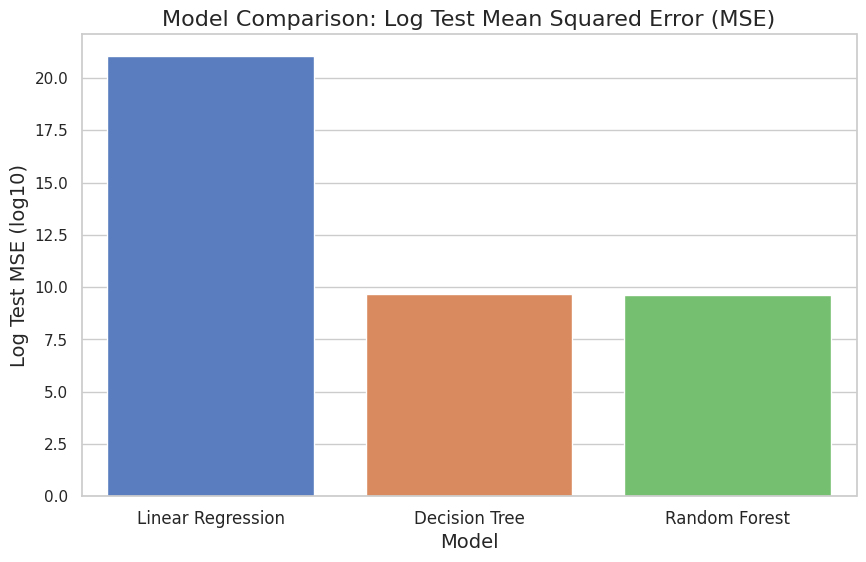

<ipython-input-16-85bd2f60aa9e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Log Avg CV MSE", data=results_df, palette="muted")


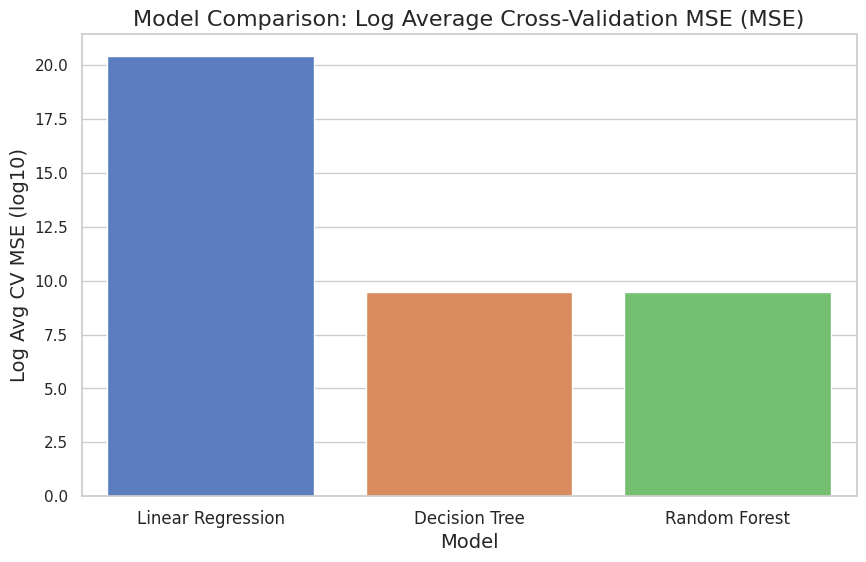

<ipython-input-16-85bd2f60aa9e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test MSE", data=filtered_results, palette="muted")


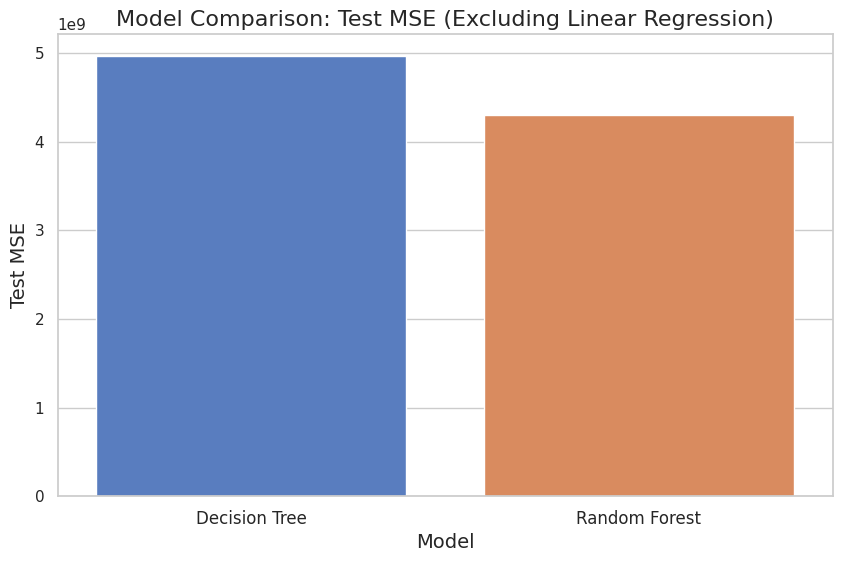

<ipython-input-16-85bd2f60aa9e>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Avg CV MSE", data=filtered_results, palette="muted")


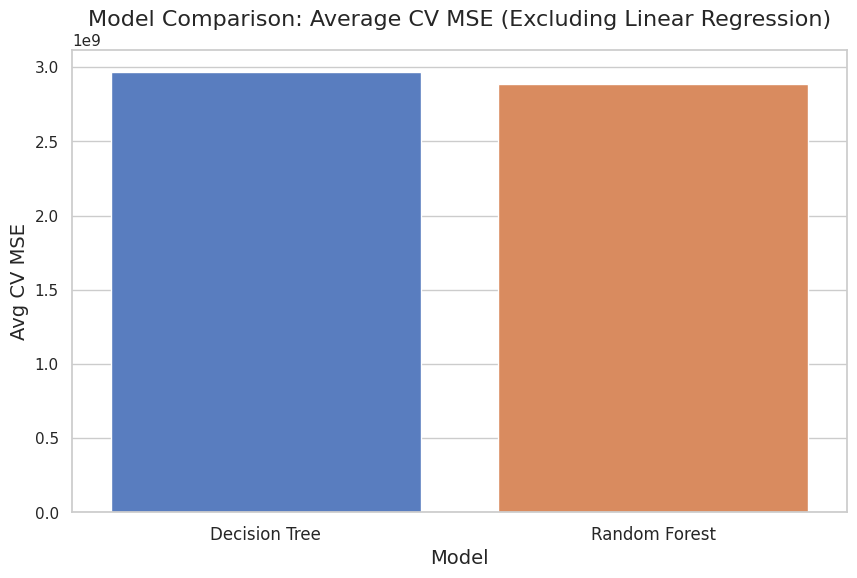

<ipython-input-16-85bd2f60aa9e>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test R²", data=results_df, palette="muted")


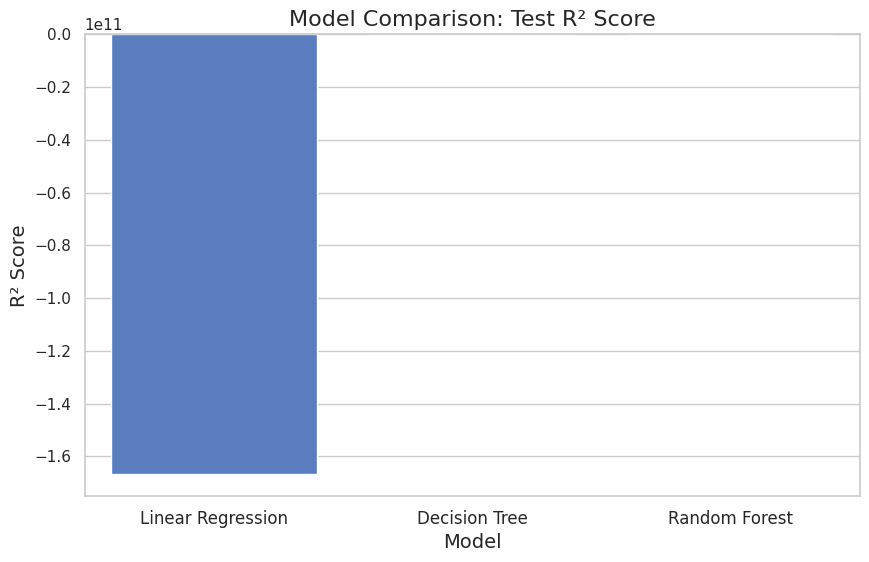

In [ ]:
# Visualization
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Add a column for log-transformed MSE (to prevent log(0) issues, add a small constant if necessary)
results_df["Log Test MSE"] = np.log10(results_df["Test MSE"].replace(0, np.nan))
results_df["Log Avg CV MSE"] = np.log10(results_df["Avg CV MSE"].replace(0, np.nan))

# 1. Visualization with Logarithmic Scale for MSE
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Log Test MSE", data=results_df, palette="muted")
plt.title("Model Comparison: Log Test Mean Squared Error (MSE)", fontsize=16)
plt.ylabel("Log Test MSE (log10)", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Log Avg CV MSE", data=results_df, palette="muted")
plt.title("Model Comparison: Log Average Cross-Validation MSE (MSE)", fontsize=16)
plt.ylabel("Log Avg CV MSE (log10)", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.show()

# 2. Visualization excluding Linear Regression
filtered_results = results_df[results_df["Model"] != "Linear Regression"]

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test MSE", data=filtered_results, palette="muted")
plt.title("Model Comparison: Test MSE (Excluding Linear Regression)", fontsize=16)
plt.ylabel("Test MSE", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Avg CV MSE", data=filtered_results, palette="muted")
plt.title("Model Comparison: Average CV MSE (Excluding Linear Regression)", fontsize=16)
plt.ylabel("Avg CV MSE", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.show()

# 3. R² Scores Visualization (no need for log transformation)
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R²", data=results_df, palette="muted")
plt.title("Model Comparison: Test R² Score", fontsize=16)
plt.ylabel("R² Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.show()
